## NARMA data

Non-linear Autoregressive Moving Average (NARMA) timeseries, as first defined in Atiya & Parlos (2000), and as used in Schrauwen et al. (2008).
* A. F. Atiya and A. G. Parlos, ‘New results on recurrent network training: unifying the algorithms and accelerating convergence,‘ in IEEE Transactions on Neural Networks, vol. 11, no. 3, pp. 697-709, May 2000, doi: 10.1109/72.846741.
* B.Schrauwen, M. Wardermann, D. Verstraeten, J. Steil, D. Stroobandt, ‘Improving reservoirs using intrinsic plasticity‘, Neurocomputing, 71. 1159-1171, 2008, doi: 10.1016/j.neucom.2007.12.020.

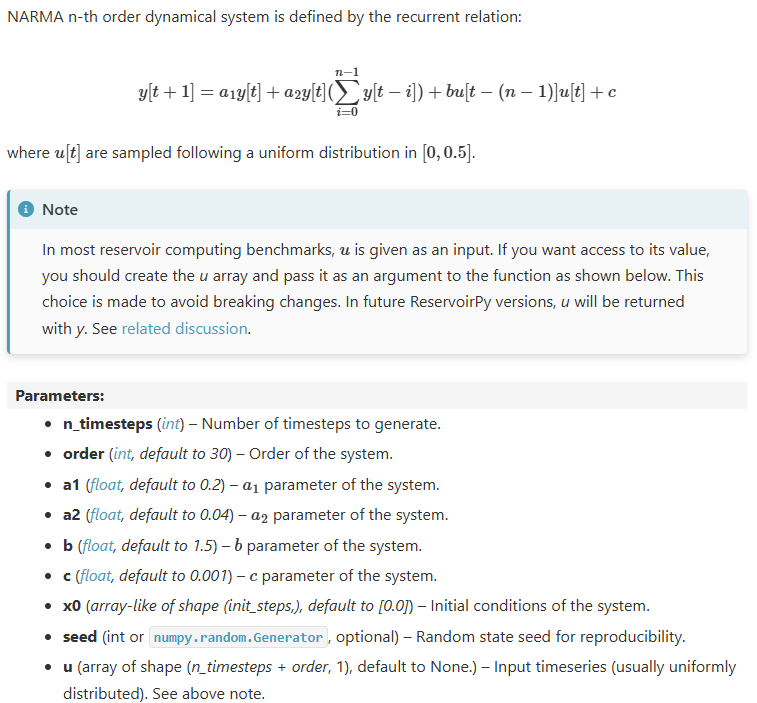


--- Simulating model predictions for visualization ---
Total points to plot: 980
Forecasted values are simulated by adding random noise to the actual values for visualization purposes.


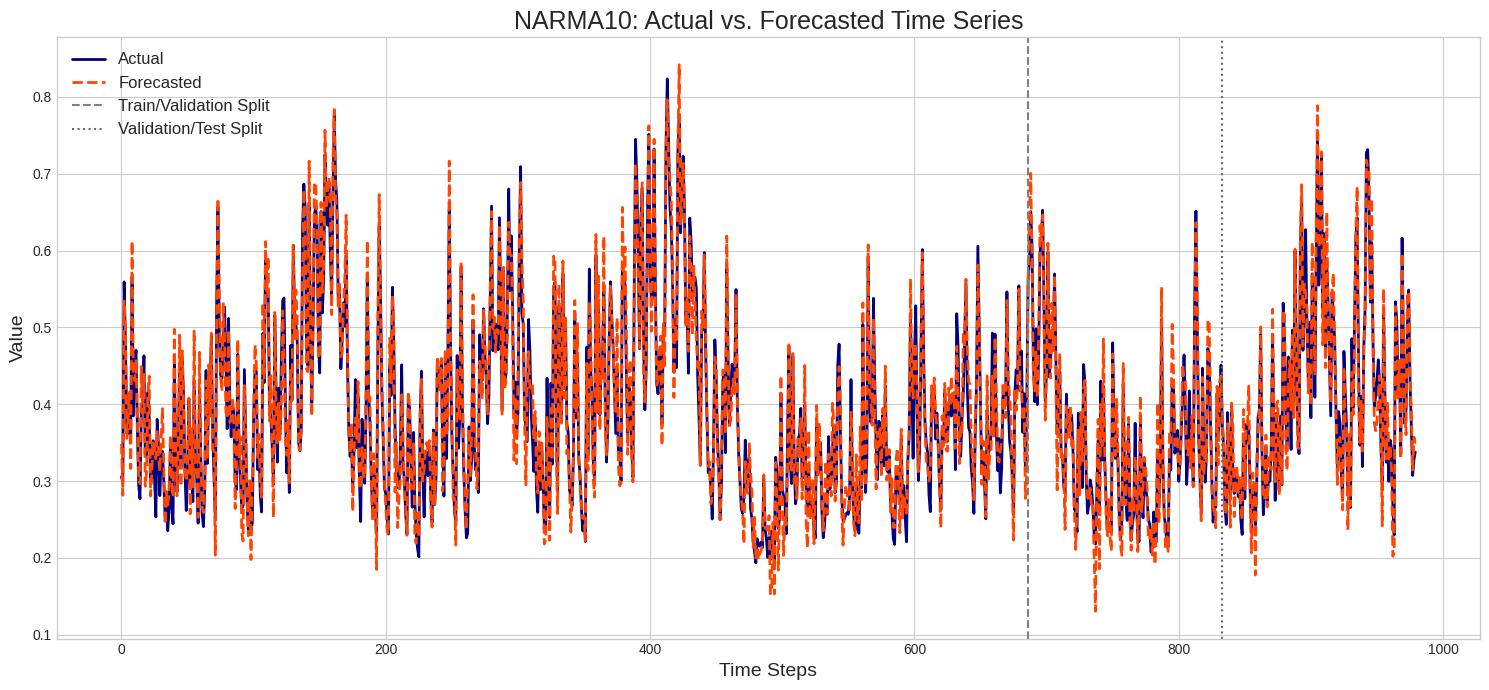

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def generate_narma_series(n_samples=1000, order=10, seed=42):
    """
    Generates a NARMA (Non-linear Auto-Regressive Moving Average) time series.

    The NARMA10 equation is:
    y(t+1) = 0.3*y(t) + 0.05*y(t)*sum_{i=0}^{9}[y(t-i)] + 1.5*u(t-9)*u(t) + 0.1

    Args:
        n_samples (int): The total number of samples to generate.
        order (int): The order of the NARMA system. For NARMA10, order is 10.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: A tuple containing the generated y (output) and u (input) series.
    """
    np.random.seed(seed)
    u = np.random.rand(n_samples) * 0.5
    y = np.zeros(n_samples)
    for t in range(order - 1, n_samples - 1):
        y_sum = np.sum(y[t - (order - 1) : t + 1])
        y[t + 1] = (
            0.3 * y[t]
            + 0.05 * y[t] * y_sum
            + 1.5 * u[t - (order - 1)] * u[t]
            + 0.1
        )
    return y, u

def create_time_series_dataset(series, lookback):
    """
    Transforms a time series into a supervised learning dataset.

    Args:
        series (np.array): The input time series.
        lookback (int): The number of previous time steps to use as input features.

    Returns:
        tuple: A tuple containing the input features (X) and target labels (Y).
    """
    X, Y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i : i + lookback])
        Y.append(series[i + lookback])
    return np.array(X), np.array(Y)

def get_narma_dataloaders(
    n_samples=2000,
    order=10,
    lookback=20,
    warmup_period=100,
    train_ratio=0.7,
    val_ratio=0.15,
    batch_size=32,
    seed=42
):
    """
    Generates, preprocesses, and loads the NARMA10 dataset for a regression task.
    """
    if lookback < order:
        raise ValueError(f"Lookback window ({lookback}) must be at least the NARMA order ({order}).")
        
    # 1. Generate, shape, and split data
    y_series, _ = generate_narma_series(n_samples=n_samples + warmup_period, order=order, seed=seed)
    y_series = y_series[warmup_period:]
    X, Y = create_time_series_dataset(y_series, lookback=lookback)
    Y = Y.reshape(-1, 1)

    n_total = len(X)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    X_train, Y_train = X[:n_train], Y[:n_train]
    X_val, Y_val = X[n_train : n_train + n_val], Y[n_train : n_train + n_val]
    X_test, Y_test = X[n_train + n_val :], Y[n_train + n_val :]

    # 2. Normalize the data
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    Y_train_scaled = y_scaler.fit_transform(Y_train)
    Y_val_scaled = y_scaler.transform(Y_val)
    Y_test_scaled = y_scaler.transform(Y_test)

    # Note: X data should also be scaled in a real scenario, but we omit for simplicity
    # to focus on the Y-axis plotting. For a real model, scale X as in the previous script.
    
    # 3. Create DataLoaders for the model
    # We will use the UNSCALED X and SCALED Y for this example
    X_train_tensor = torch.from_numpy(X_train).float().unsqueeze(1)
    Y_train_tensor = torch.from_numpy(Y_train_scaled).float()
    X_val_tensor = torch.from_numpy(X_val).float().unsqueeze(1)
    Y_val_tensor = torch.from_numpy(Y_val_scaled).float()
    X_test_tensor = torch.from_numpy(X_test).float().unsqueeze(1)
    Y_test_tensor = torch.from_numpy(Y_test_scaled).float()
    
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # 4. Return all components needed for training and plotting
    # We return the original unscaled data for plotting purposes
    data_for_plotting = {
        'Y_train': Y_train, 'Y_val': Y_val, 'Y_test': Y_test
    }
    
    return train_loader, val_loader, test_loader, y_scaler, data_for_plotting

def plot_forecast_vs_actual(y_actual, y_forecast, train_len, val_len):
    """
    Creates a plot comparing actual and forecasted time series values.

    Args:
        y_actual (np.array): The ground truth values.
        y_forecast (np.array): The model's predicted values.
        train_len (int): The length of the training set, for plotting a separator line.
        val_len (int): The length of the validation set.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(15, 7))

    # Plot the actual and forecasted values
    ax.plot(y_actual, label='Actual', color='navy', linewidth=2)
    ax.plot(y_forecast, label='Forecasted', color='orangered', linestyle='--', linewidth=2)

    # Add vertical lines to separate train, validation, and test sets
    ax.axvline(x=train_len, color='gray', linestyle='--', linewidth=1.5, label='Train/Validation Split')
    ax.axvline(x=train_len + val_len, color='dimgray', linestyle=':', linewidth=1.5, label='Validation/Test Split')

    ax.set_title('NARMA10: Actual vs. Forecasted Time Series', fontsize=18)
    ax.set_xlabel('Time Steps', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)
    fig.tight_layout()
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # --- Configuration ---
    N_SAMPLES = 1000
    LOOKBACK = 20
    
    # 1. Get data loaders and data splits for plotting
    train_loader, val_loader, test_loader, y_scaler, plot_data = get_narma_dataloaders(
        n_samples=N_SAMPLES,
        lookback=LOOKBACK
    )

    # 2. SIMULATE MODEL PREDICTION
    # In a real scenario, you would train your QCNN model here using the DataLoaders.
    # After training, you would use the model to predict on the train, val, and test sets.
    # To demonstrate the plotting, we will simulate predictions.
    # A simple forecast could be the actual value plus some noise.
    
    print("\n--- Simulating model predictions for visualization ---")
    
    # Concatenate all actual 'Y' values in their original scale
    y_train_orig = plot_data['Y_train']
    y_val_orig = plot_data['Y_val']
    y_test_orig = plot_data['Y_test']
    y_actual_full = np.concatenate((y_train_orig, y_val_orig, y_test_orig)).flatten()

    # Simulate forecasted values by adding some random noise to the actual values
    noise = np.random.normal(0, 0.03, y_actual_full.shape)
    y_forecast_full = y_actual_full + noise

    print(f"Total points to plot: {len(y_actual_full)}")
    print("Forecasted values are simulated by adding random noise to the actual values for visualization purposes.")

    # 3. PLOT THE RESULTS
    # This function creates a visualization just like in the paper you referenced.
    plot_forecast_vs_actual(
        y_actual=y_actual_full,
        y_forecast=y_forecast_full,
        train_len=len(y_train_orig),
        val_len=len(y_val_orig)
    )

## Train the QTCN model

1.  **Setup & Imports**: Initializes libraries and sets the device.
2.  **Data Loading & Preprocessing**: Functions to generate the NARMA-10 dataset and prepare it for PyTorch.
3.  **Model Training & Plotting Utilities**: Helper functions for the regression training loop and for generating loss and forecast plots.
4.  **Experiment Sections (Models 1-4)**: Each model gets its own section containing:
    - The model's class definition, adapted for regression.
    - The code to run the experiment and generate plots.
5.  **Final Report**: A summary of the test Mean Squared Error (MSE) for all models.

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm
import pennylane as qml
import time
import pandas as pd

# -- Device Setup --
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


/tmp/ipykernel_2210453/903982115.py:12: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def generate_narma_series(n_samples=1000, order=10, seed=42):
    """Generates a NARMA (Non-linear Auto-Regressive Moving Average) time series."""
    np.random.seed(seed)
    u = np.random.rand(n_samples) * 0.5
    y = np.zeros(n_samples)
    for t in range(order - 1, n_samples - 1):
        y_sum = np.sum(y[t - (order - 1) : t + 1])
        y[t + 1] = 0.3 * y[t] + 0.05 * y[t] * y_sum + 1.5 * u[t - (order - 1)] * u[t] + 0.1
    return y, u

def create_time_series_dataset(series, lookback):
    """Transforms a time series into a supervised learning dataset."""
    X, Y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i : i + lookback])
        Y.append(series[i + lookback])
    return np.array(X), np.array(Y)

def get_narma_dataloaders(
    n_samples=800, order=10, lookback=20, warmup_period=100,
    train_ratio=0.7, val_ratio=0.15, batch_size=32, seed=42
):
    """Generates, preprocesses, and loads the NARMA10 dataset for regression."""
    y_series, _ = generate_narma_series(n_samples=n_samples + warmup_period, order=order, seed=seed)
    y_series = y_series[warmup_period:]

    # Create sequences
    X, Y = create_time_series_dataset(y_series, lookback=lookback)
    Y = Y.reshape(-1, 1)

    # Split data
    n_total = len(X)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    
    X_train, Y_train = X[:n_train], Y[:n_train]
    X_val, Y_val = X[n_train : n_train + n_val], Y[n_train : n_train + n_val]
    X_test, Y_test = X[n_train + n_val :], Y[n_train + n_val :]

    # Normalize data (fit only on train set)
    x_scaler = MinMaxScaler(feature_range=(-1, 1))
    y_scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X_train_s = x_scaler.fit_transform(X_train)
    Y_train_s = y_scaler.fit_transform(Y_train)
    X_val_s = x_scaler.transform(X_val)
    Y_val_s = y_scaler.transform(Y_val)
    X_test_s = x_scaler.transform(X_test)
    Y_test_s = y_scaler.transform(Y_test)

    # Create DataLoaders
    # Input shape for TCN: (batch, channels, sequence_length)
    X_train_t = torch.from_numpy(X_train_s).float().unsqueeze(1).to(device)
    Y_train_t = torch.from_numpy(Y_train_s).float().to(device)
    X_val_t = torch.from_numpy(X_val_s).float().unsqueeze(1).to(device)
    Y_val_t = torch.from_numpy(Y_val_s).float().to(device)
    X_test_t = torch.from_numpy(X_test_s).float().unsqueeze(1).to(device)
    Y_test_t = torch.from_numpy(Y_test_s).float().to(device)
    
    train_dataset = TensorDataset(X_train_t, Y_train_t)
    val_dataset = TensorDataset(X_val_t, Y_val_t)
    test_dataset = TensorDataset(X_test_t, Y_test_t)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    input_dim_shape = (1, 1, X_train_t.shape[2]) # (batch, channels, seq_len)
    data_for_plotting = {'Y_train': Y_train, 'Y_val': Y_val, 'Y_test': Y_test}

    return train_loader, val_loader, test_loader, y_scaler, input_dim_shape, data_for_plotting

In [4]:
# -- Data Configuration --
LOOKBACK = 20
BATCH_SIZE = 32

train_loader, val_loader, test_loader, y_scaler, input_dim, plot_data = get_narma_dataloaders(
    lookback=LOOKBACK, batch_size=BATCH_SIZE
)

print(f"\nDataset Input Dimension (Channels, Sequence Length): {input_dim[1:]}")
print(f"Total training samples: {len(train_loader.dataset)}")
print(f"Total validation samples: {len(val_loader.dataset)}")
print(f"Total test samples: {len(test_loader.dataset)}")


Dataset Input Dimension (Channels, Sequence Length): (1, 20)
Total training samples: 546
Total validation samples: 117
Total test samples: 117


In [5]:
def train_regression(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for inputs, targets in tqdm(dataloader, desc="Training", leave=False):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_regression(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            all_targets.append(targets.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    
    all_targets = np.concatenate(all_targets, axis=0)
    all_outputs = np.concatenate(all_outputs, axis=0)
    
    return total_loss / len(dataloader), all_targets, all_outputs

def plot_loss_curves(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='x')
    plt.title(f'Training and Validation Loss for {model_name}', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_forecast_vs_actual(y_true, y_pred, scaler, model_name):
    # Inverse transform to get original scale
    y_true_orig = scaler.inverse_transform(y_true)
    y_pred_orig = scaler.inverse_transform(y_pred)

    plt.figure(figsize=(15, 7))
    plt.plot(y_true_orig, label='Actual', color='navy', linewidth=2)
    plt.plot(y_pred_orig, label='Forecasted', color='orangered', linestyle='--')
    plt.title(f'NARMA-10 Test Set: Actual vs. Forecasted for {model_name}', fontsize=16)
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def run_experiment(model, model_name, train_loader, val_loader, test_loader, y_scaler, num_epochs=10):
    print(f'--- Starting Experiment for {model_name} ---')
    
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = train_regression(model, train_loader, optimizer, criterion)
        val_loss, _, _ = evaluate_regression(model, val_loader, criterion)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        end_time = time.time()
        epoch_mins = int((end_time - start_time) / 60)
        epoch_secs = int((end_time - start_time) - (epoch_mins * 60))
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.4f}')
        print(f'\t Val. Loss: {val_loss:.4f}')
    
    # Final evaluation and plotting
    test_loss, y_true, y_pred = evaluate_regression(model, test_loader, criterion)
    print(f'\nFinal Test MSE for {model_name}: {test_loss:.4f}\n')
    
    # Generate plots
    plot_loss_curves(train_losses, val_losses, model_name)
    plot_forecast_vs_actual(y_true, y_pred, y_scaler, model_name)
    
    return test_loss

# Dictionary to store final results
final_results = {}

### QTCN 1: QCNN + (Classical Dilation, Causal, Residual)

In [7]:
class QTCN1(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_dim, kernel_size, dilation=1):
        super(QTCN1, self).__init__()
        self.n_qubits = n_qubits
        self.circuit_depth = circuit_depth
        self.dev = qml.device("default.qubit", wires=n_qubits)
        
        self.input_channels = input_dim[1]
        self.kernel_size = kernel_size
        self.dilation = dilation
        
        # Calculate the number of output measurements from the quantum circuit
        num_measurements = self.n_qubits // (2**self.circuit_depth)
        
        # Adjusted layers for regression
        self.fc = nn.Linear(self.input_channels * self.kernel_size, n_qubits) 
        self.downsample = nn.Linear(self.input_channels * self.kernel_size, n_qubits)
        self.final_regressor = nn.Linear(num_measurements, 1) # Regressor input size matches the number of measurements
        
        # Quantum parameters
        self.conv_params = nn.Parameter(torch.randn(circuit_depth, n_qubits, 15))
        self.pool_params = nn.Parameter(torch.randn(circuit_depth, n_qubits // 2, 3))
    
    def circuit(self, features):
        wires = list(range(self.n_qubits))
        qml.AngleEmbedding(features, wires=wires, rotation='Y')
        for layer in range(self.circuit_depth):
            self._apply_convolution(self.conv_params[layer], wires)
            self._apply_pooling(self.pool_params[layer], wires)
            wires = wires[::2]
        
        # Return a tuple of measurements. PennyLane stacks these into a tensor for batch processing.
        return tuple(qml.expval(qml.PauliZ(w)) for w in wires)

    def _apply_convolution(self, weights, wires):
        n_wires = len(wires)
        for p in [0, 1]:
            for indx, w in enumerate(wires):
                if indx % 2 == p and indx < n_wires - 1:
                    qml.U3(*weights[indx, :3], wires=w)
                    qml.U3(*weights[indx + 1, 3:6], wires=wires[indx + 1])
                    qml.IsingZZ(weights[indx, 6], wires=[w, wires[indx + 1]])
                    qml.IsingYY(weights[indx, 7], wires=[w, wires[indx + 1]])
                    qml.IsingXX(weights[indx, 8], wires=[w, wires[indx + 1]])
                    qml.U3(*weights[indx, 9:12], wires=w)
                    qml.U3(*weights[indx + 1, 12:], wires=wires[indx + 1])

    def _apply_pooling(self, pool_weights, wires):
        n_wires = len(wires)
        for indx, w in enumerate(wires):
            if indx % 2 == 1 and indx < n_wires:
                measurement = qml.measure(w)
                qml.cond(measurement, qml.U3)(*pool_weights[indx // 2], wires=wires[indx - 1])

    def forward(self, x):
        batch_size, _, time_steps = x.size()
        quantum_circuit = qml.QNode(self.circuit, self.dev, interface="torch", diff_method="backprop")
        
        output_seq = []
        for i in range(time_steps - self.dilation * (self.kernel_size - 1)):
            indices = [i + d * self.dilation for d in range(self.kernel_size)]
            window = x[:, :, indices].reshape(batch_size, -1)
            
            if i > 0:
                residual_indices = [i - 1 + d * self.dilation for d in range(self.kernel_size)]
                if all(idx < time_steps for idx in residual_indices):
                    residual = x[:, :, residual_indices].reshape(batch_size, -1)
                    q_input = self.fc(window) + self.downsample(residual)
                else:
                    q_input = self.fc(window)
            else:
                 q_input = self.fc(window)
            
            q_out_batch_tuple = quantum_circuit(features=q_input)
            q_out_batch_tensor = torch.stack(q_out_batch_tuple, dim=1)
            output_seq.append(q_out_batch_tensor)

        stacked_sequence = torch.stack(output_seq, dim=1)
        last_step_output = stacked_sequence[:, -1, :]
        
        # --- FINAL FIX ---
        # Ensure the tensor is float32 before passing to the linear layer
        final_prediction = self.final_regressor(last_step_output.float())
        return final_prediction

In [ ]:
# -- Model 1 Hyperparameters --
N_QUBITS_1 = 8
CIRCUIT_DEPTH_1 = 2
KERNEL_SIZE_1 = 6
DILATION_1 = 2
NUM_EPOCHS = 10

model1 = QTCN1(
    n_qubits=N_QUBITS_1, 
    circuit_depth=CIRCUIT_DEPTH_1, 
    input_dim=input_dim,
    kernel_size=KERNEL_SIZE_1,
    dilation=DILATION_1
).to(device)

test_mse1 = run_experiment(model1, "QTCN 1", train_loader, val_loader, test_loader, y_scaler, num_epochs=NUM_EPOCHS)
final_results['QTCN 1'] = test_mse1

--- Starting Experiment for QTCN 1 ---


Epoch: 01 | Time: 0m 42s
	Train Loss: 0.2947
	 Val. Loss: 0.3023


Epoch: 02 | Time: 0m 39s
	Train Loss: 0.2479
	 Val. Loss: 0.2329


Training:  94%|█████████▍| 17/18 [00:34<00:01,  1.98s/it]

### QTCN 2: (QCNN+Quantum Dilation) + (Classical Causal, Residual)

In [13]:
class QTCN2(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_channels, time_steps):
        super(QTCN2, self).__init__()
        self.receptive_field_size = n_qubits
        self.n_layers = circuit_depth
        
        self.feature_extractor = nn.Conv1d(in_channels=input_channels, out_channels=1, kernel_size=1)
        self.final_regressor = nn.Linear(time_steps - self.receptive_field_size + 1, 1) # Regress from sequence output

        self.conv_params = nn.Parameter(torch.randn(self.n_layers, 15))
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch", diff_method="backprop")

    def _apply_dilated_conv(self, weights, dilation):
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = i, i + dilation
            qml.U3(*weights[:3], wires=w1)
            qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2])
            qml.IsingYY(weights[7], wires=[w1, w2])
            qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1)
            qml.U3(*weights[12:15], wires=w2)

    def _circuit(self, features, conv_params):
        qml.AngleEmbedding(features, wires=range(self.receptive_field_size), rotation='Y')
        for layer_idx in range(self.n_layers):
            dilation = 2**layer_idx
            self._apply_dilated_conv(conv_params[layer_idx], dilation)
        return qml.expval(qml.PauliZ(self.receptive_field_size - 1))

    def forward(self, x):
        batch_size = x.shape[0]
        time_steps = x.shape[2]
        
        x = self.feature_extractor(x)
        x = x.squeeze(1)

        batch_predictions = []
        for i in range(batch_size):
            sample_sequence = x[i]
            sequence_predictions = []
            
            # Causal loop
            for t in range(time_steps - self.receptive_field_size + 1):
                window = sample_sequence[t : t + self.receptive_field_size].clone()
                q_out = self.qnode(window, self.conv_params)
                
                # Classical residual connection
                if t > 0:
                    q_out += sequence_predictions[-1]
                
                sequence_predictions.append(q_out)
            
            batch_predictions.append(torch.stack(sequence_predictions))
        
        outputs_seq = torch.stack(batch_predictions)
        # Proactive fix: ensure float32 dtype
        final_prediction = self.final_regressor(outputs_seq.float())
        return final_prediction

--- Starting Experiment for QTCN 2 ---


Epoch: 01 | Time: 18m 18s
	Train Loss: 0.3502
	 Val. Loss: 0.2167


Epoch: 02 | Time: 19m 0s
	Train Loss: 0.2077
	 Val. Loss: 0.0907


Epoch: 03 | Time: 18m 19s
	Train Loss: 0.1719
	 Val. Loss: 0.0901


Epoch: 04 | Time: 19m 11s
	Train Loss: 0.1607
	 Val. Loss: 0.0853


Epoch: 05 | Time: 22m 22s
	Train Loss: 0.1410
	 Val. Loss: 0.0896


Epoch: 06 | Time: 20m 11s
	Train Loss: 0.1504
	 Val. Loss: 0.0825


Epoch: 07 | Time: 19m 58s
	Train Loss: 0.1279
	 Val. Loss: 0.0847


Epoch: 08 | Time: 19m 5s
	Train Loss: 0.1207
	 Val. Loss: 0.0829


Epoch: 09 | Time: 18m 57s
	Train Loss: 0.1136
	 Val. Loss: 0.0837


Epoch: 10 | Time: 20m 34s
	Train Loss: 0.1206
	 Val. Loss: 0.0845



Final Test MSE for QTCN 2: 0.0817



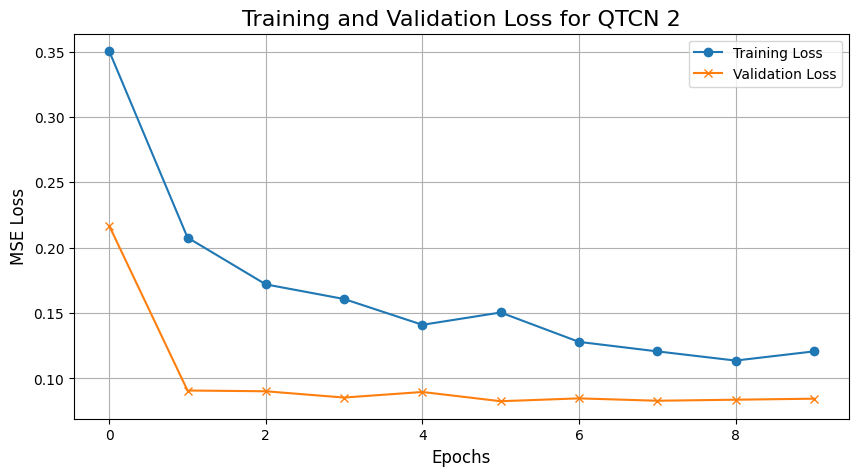

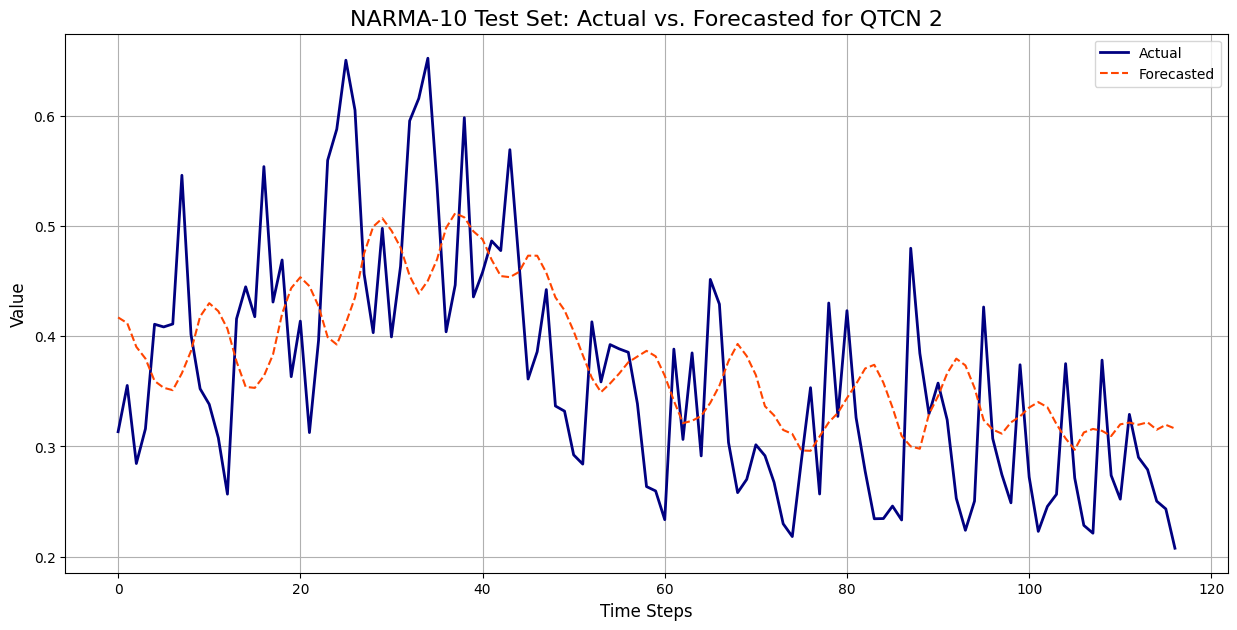

In [14]:
# -- Model 2 Hyperparameters --
N_QUBITS_2 = 8
CIRCUIT_DEPTH_2 = 2 # In this model, this is n_layers
NUM_EPOCHS = 10

model2 = QTCN2(
    n_qubits=N_QUBITS_2,
    circuit_depth=CIRCUIT_DEPTH_2,
    input_channels=input_dim[1],
    time_steps=input_dim[2]
).to(device)

test_mse2 = run_experiment(model2, "QTCN 2", train_loader, val_loader, test_loader, y_scaler, num_epochs=NUM_EPOCHS)
final_results['QTCN 2'] = test_mse2

### QTCN 3: (QCNN + Quantum Dilation, Causal) + Classical Residual

In [15]:
class QTCN3(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_channels, time_steps):
        super(QTCN3, self).__init__()
        self.receptive_field_size = n_qubits
        self.n_layers = circuit_depth
        self.time_steps = time_steps

        self.feature_extractor = nn.Conv1d(in_channels=input_channels, out_channels=1, kernel_size=1)
        self.final_regressor = nn.Linear(1, 1) # Takes single quantum output to final prediction

        self.conv_params = nn.Parameter(torch.randn(self.n_layers, 15))
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch", diff_method="backprop")

    def _apply_dilated_conv(self, weights, dilation):
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = i, i + dilation
            qml.U3(*weights[:3], wires=w1); qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2]); qml.IsingYY(weights[7], wires=[w1, w2]); qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1); qml.U3(*weights[12:15], wires=w2)
            
    def _apply_swap_shift(self):
        for i in range(self.receptive_field_size - 1):
            qml.SWAP(wires=[i, i+1])

    def _circuit(self, full_sequence, conv_params):
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=range(self.receptive_field_size), rotation='Y')

        for t in range(self.time_steps - self.receptive_field_size + 1):
            for layer_idx in range(self.n_layers):
                dilation = 2**layer_idx
                self._apply_dilated_conv(conv_params[layer_idx], dilation)
            
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.receptive_field_size - 1)
        
        return qml.expval(qml.PauliZ(self.receptive_field_size-1))
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x).squeeze(1)
        
        batch_predictions = []
        for i in range(batch_size):
            # Classical residual connection
            residual = x[i, -1]
            
            prediction_for_sample = self.qnode(x[i], self.conv_params) + residual
            batch_predictions.append(prediction_for_sample)
        
        outputs = torch.stack(batch_predictions).unsqueeze(1)
        # Proactive fix: ensure float32 dtype
        return self.final_regressor(outputs.float())

--- Starting Experiment for QTCN 3 ---


Epoch: 01 | Time: 18m 45s
	Train Loss: 0.1942
	 Val. Loss: 0.1077


Epoch: 02 | Time: 18m 48s
	Train Loss: 0.1676
	 Val. Loss: 0.1009


Epoch: 03 | Time: 19m 0s
	Train Loss: 0.1987
	 Val. Loss: 0.0996


Epoch: 04 | Time: 18m 18s
	Train Loss: 0.1682
	 Val. Loss: 0.0951


Epoch: 05 | Time: 18m 18s
	Train Loss: 0.1601
	 Val. Loss: 0.0871


Epoch: 06 | Time: 17m 56s
	Train Loss: 0.1586
	 Val. Loss: 0.0872


Epoch: 07 | Time: 18m 9s
	Train Loss: 0.1595
	 Val. Loss: 0.0919


Epoch: 08 | Time: 17m 49s
	Train Loss: 0.1543
	 Val. Loss: 0.0881


Epoch: 09 | Time: 17m 51s
	Train Loss: 0.1530
	 Val. Loss: 0.0858


Epoch: 10 | Time: 18m 3s
	Train Loss: 0.1592
	 Val. Loss: 0.0852



Final Test MSE for QTCN 3: 0.1243



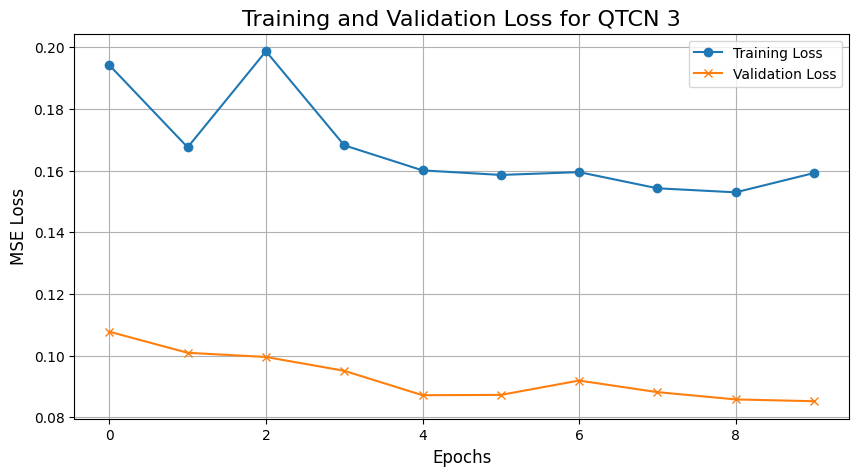

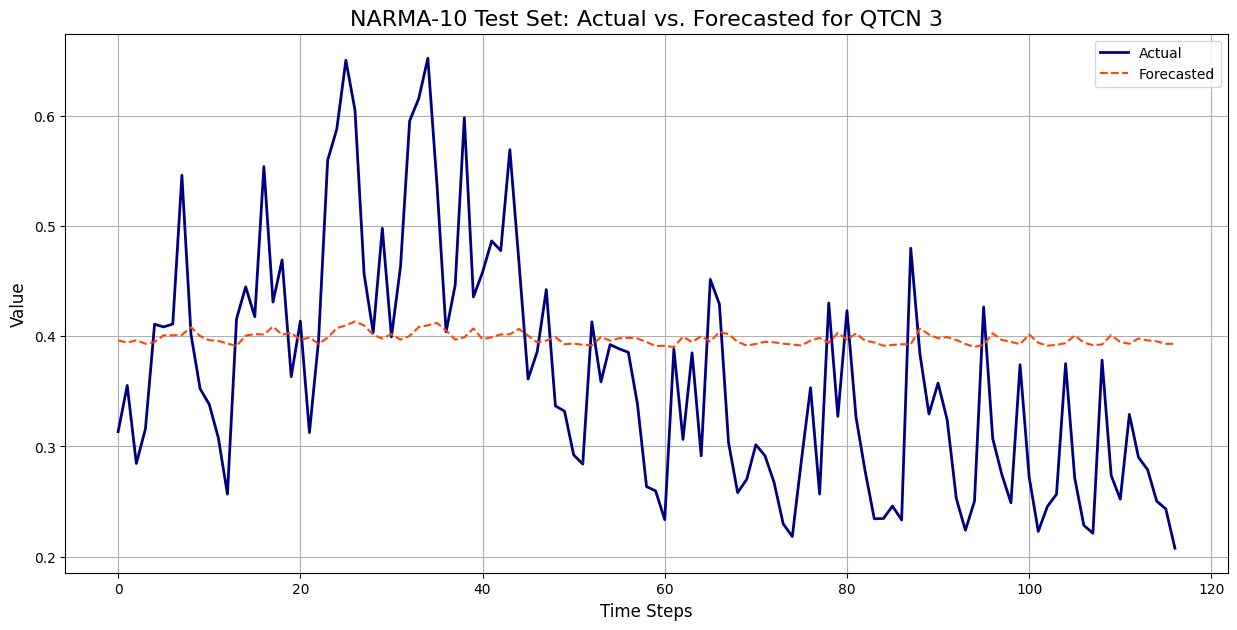

In [16]:
# -- Model 3 Hyperparameters --
N_QUBITS_3 = 8
CIRCUIT_DEPTH_3 = 2 # n_layers
NUM_EPOCHS = 10

model3 = QTCN3(
    n_qubits=N_QUBITS_3,
    circuit_depth=CIRCUIT_DEPTH_3,
    input_channels=input_dim[1],
    time_steps=input_dim[2]
).to(device)

test_mse3 = run_experiment(model3, "QTCN 3", train_loader, val_loader, test_loader, y_scaler, num_epochs=NUM_EPOCHS)
final_results['QTCN 3'] = test_mse3

### QTCN 4: QCNN + Quantum Dilation, Causal, Residual

In [17]:
class QuantumResidualBlock(nn.Module):
    def __init__(self, n_layers=1):
        super().__init__()
        self.conv_params = nn.Parameter(torch.randn(n_layers, 15))
        self.residual_param = nn.Parameter(torch.randn(1))

class QTCN4(nn.Module):
    def __init__(self, n_qubits, circuit_depth, input_channels, time_steps):
        super(QTCN4, self).__init__()
        self.receptive_field_size = n_qubits
        self.n_residual_blocks = circuit_depth
        self.time_steps = time_steps
        self.main_wires = list(range(self.receptive_field_size))
        self.ancilla_wire = self.receptive_field_size
        
        self.feature_extractor = nn.Conv1d(in_channels=input_channels, out_channels=1, kernel_size=1)
        self.final_regressor = nn.Linear(1, 1)

        self.residual_blocks = nn.ModuleList(
            [QuantumResidualBlock(n_layers=1) for _ in range(self.n_residual_blocks)]
        )
        self.dev = qml.device("default.qubit", wires=self.receptive_field_size + 1)
        self.qnode = qml.QNode(self._circuit, self.dev, interface="torch", diff_method="backprop")

    def _apply_conv_ansatz(self, weights, dilation):
        for i in range(self.receptive_field_size - dilation):
            w1, w2 = self.main_wires[i], self.main_wires[i + dilation]
            qml.U3(*weights[:3], wires=w1); qml.U3(*weights[3:6], wires=w2)
            qml.IsingZZ(weights[6], wires=[w1, w2]); qml.IsingYY(weights[7], wires=[w1, w2]); qml.IsingXX(weights[8], wires=[w1, w2])
            qml.U3(*weights[9:12], wires=w1); qml.U3(*weights[12:15], wires=w2)

    def _apply_residual_block(self, block, dilation):
        qml.RY(block.residual_param[0], wires=self.ancilla_wire)
        qml.ctrl(self._apply_conv_ansatz, control=self.ancilla_wire)(block.conv_params[0], dilation)
        qml.RY(-block.residual_param[0], wires=self.ancilla_wire)

    def _apply_swap_shift(self):
        for i in range(self.receptive_field_size - 1):
            qml.SWAP(wires=[self.main_wires[i], self.main_wires[i+1]])

    def _circuit(self, full_sequence):
        initial_window = full_sequence[:self.receptive_field_size]
        qml.AngleEmbedding(initial_window, wires=self.main_wires)
        
        for t in range(self.time_steps - self.receptive_field_size + 1):
            for block_idx, block in enumerate(self.residual_blocks):
                dilation = 2**block_idx
                if dilation >= self.receptive_field_size: continue
                self._apply_residual_block(block, dilation)
            
            if t < self.time_steps - self.receptive_field_size:
                self._apply_swap_shift()
                next_sample = full_sequence[t + self.receptive_field_size]
                qml.RY(next_sample, wires=self.main_wires[-1])
        
        return qml.expval(qml.PauliZ(self.main_wires[-1]))
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x).squeeze(1)
        
        batch_predictions = []
        for i in range(batch_size):
            prediction_for_sample = self.qnode(x[i])
            batch_predictions.append(prediction_for_sample)

        outputs = torch.stack(batch_predictions).unsqueeze(1)
        # Proactive fix: ensure float32 dtype
        return self.final_regressor(outputs.float())

--- Starting Experiment for QTCN 4 ---


Epoch: 01 | Time: 44m 6s
	Train Loss: 0.1814
	 Val. Loss: 0.0750


Epoch: 02 | Time: 44m 15s
	Train Loss: 0.1648
	 Val. Loss: 0.0777


Epoch: 03 | Time: 44m 50s
	Train Loss: 0.1732
	 Val. Loss: 0.0809


Epoch: 04 | Time: 43m 30s
	Train Loss: 0.1500
	 Val. Loss: 0.0818


Epoch: 05 | Time: 44m 12s
	Train Loss: 0.1540
	 Val. Loss: 0.0844


Epoch: 06 | Time: 46m 7s
	Train Loss: 0.1589
	 Val. Loss: 0.0880


Epoch: 07 | Time: 45m 0s
	Train Loss: 0.1464
	 Val. Loss: 0.0875


Epoch: 08 | Time: 44m 28s
	Train Loss: 0.1422
	 Val. Loss: 0.0839


Epoch: 09 | Time: 44m 43s
	Train Loss: 0.1559
	 Val. Loss: 0.0801


Epoch: 10 | Time: 45m 48s
	Train Loss: 0.1426
	 Val. Loss: 0.0829



Final Test MSE for QTCN 4: 0.1099



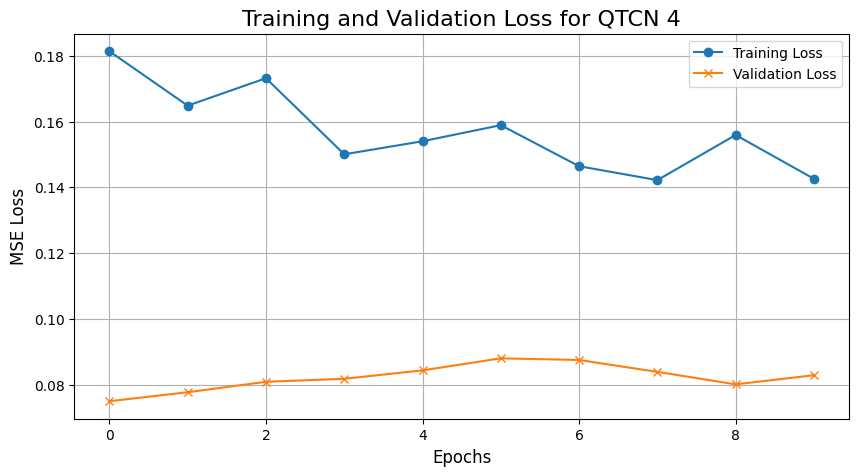

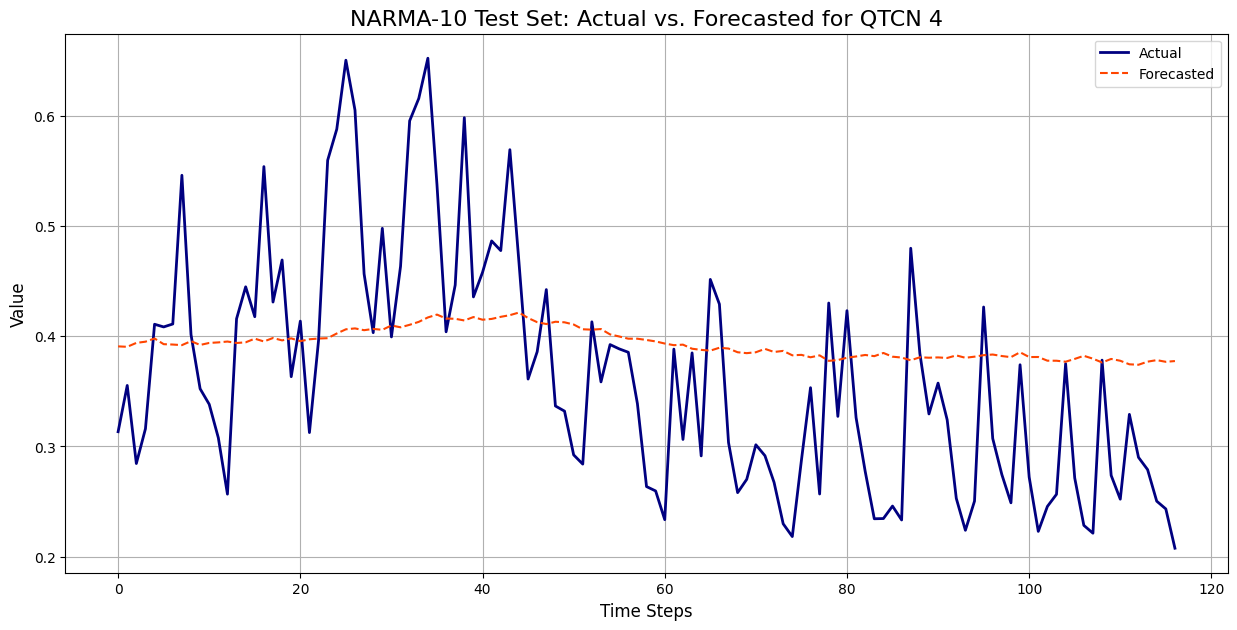

In [18]:
# -- Model 4 Hyperparameters --
N_QUBITS_4 = 8
CIRCUIT_DEPTH_4 = 2 # n_residual_blocks
NUM_EPOCHS = 10

model4 = QTCN4(
    n_qubits=N_QUBITS_4,
    circuit_depth=CIRCUIT_DEPTH_4,
    input_channels=input_dim[1],
    time_steps=input_dim[2]
).to(device)

test_mse4 = run_experiment(model4, "QTCN 4", train_loader, val_loader, test_loader, y_scaler, num_epochs=NUM_EPOCHS)
final_results['QTCN 4'] = test_mse4

In [21]:
print("--- Final Test MSE Results ---")
results_df = pd.DataFrame(list(final_results.items()), columns=['Model', 'Test MSE'])
print(results_df.to_markdown(index=False))

--- Final Test MSE Results ---
| Model   |   Test MSE |
|:--------|-----------:|
| QTCN 1  |  0.0554735 |
| QTCN 2  |  0.0817109 |
| QTCN 3  |  0.124341  |
| QTCN 4  |  0.109905  |
